In [1]:
from skimage.io import imread
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
car_image = imread("c5.jpg", as_grey=True)
# it should be a 2 dimensional array
print(car_image.shape)

(984, 1750)


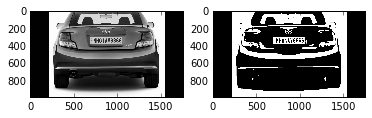

In [3]:
gray_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image, cmap="gray")
plt.show()

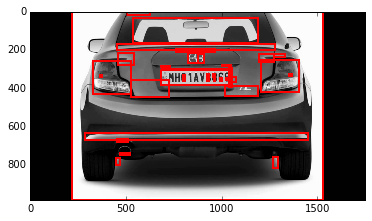

In [4]:
from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# this gets all the connected regions and groups them together
label_image = measure.label(binary_car_image)
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray");

# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    minRow, minCol, maxRow, maxCol = region.bbox
    rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)
    # let's draw a red rectangle over those regions

plt.show()

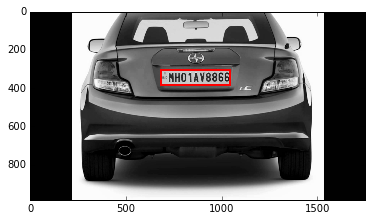

In [5]:
from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# this gets all the connected regions and groups them together
label_image = measure.label(binary_car_image)

# getting the maximum width, height and minimum width and height that a license plate can be
plate_dimensions = (0.06*label_image.shape[0], 0.10*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions
plate_objects_cordinates = []
plate_like_objects = []
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray");

# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    region_height = max_row - min_row
    region_width = max_col - min_col
    # ensuring that the region identified satisfies the condition of a typical license plate
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        plate_like_objects.append(binary_car_image[min_row:max_row,
                                  min_col:max_col])
        plate_objects_cordinates.append((min_row, min_col,
                                              max_row, max_col))
        rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
    # let's draw a red rectangle over those regions

plt.show()

[353L, 224L, 257L, 289L, 322L, 63L, 96L, 129L, 156L, 193L]


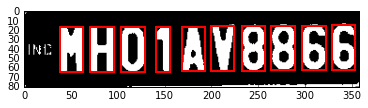

In [6]:
from skimage.transform import resize

license_plate = np.invert(plate_like_objects[0])

labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

character_dimensions = (0.35*license_plate.shape[0], 0.70*license_plate.shape[0], 0.04*license_plate.shape[1], 0.70*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X10 and then append each character into the characters list
        resized_char = resize(roi, (20, 10))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x1)
print(column_list)
plt.show()

In [7]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from skimage.io import imread
from skimage.filters import threshold_otsu

letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]

def read_training_data(training_directory):
    image_data = []
    target_data = []
    for each_letter in letters:
        for each in range(10):
            image_path = os.path.join(training_directory, each_letter, each_letter + '_' + str(each) + '.jpg')
            # read each image of each character
            img_details = imread(image_path, as_grey=True)
            # converts each character image to binary image
            binary_image = img_details < threshold_otsu(img_details)
            flat_bin_image = binary_image.reshape(-1)
            image_data.append(flat_bin_image)
            target_data.append(each_letter)
    return (np.array(image_data), np.array(target_data))

def cross_validation(model, num_of_fold, train_data, train_label):
    accuracy_result = cross_val_score(model, train_data, train_label,cv=num_of_fold)
    print("Cross Validation Result for "+ str(num_of_fold)+ " -fold")

    print(accuracy_result * 100)


current_dir = os.path.dirname(os.path.realpath('__file__'))

training_dataset_dir = os.path.join(current_dir, 'train')

image_data, target_data = read_training_data(training_dataset_dir)


svc_model = SVC(kernel='linear', probability=True)

cross_validation(svc_model, 4, image_data, target_data)

# let's train the model with all the input data
svc_model.fit(image_data, target_data)


Cross Validation Result for 4 -fold
[  96.07843137   98.03921569   97.05882353  100.        ]


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
classification_result = []
for each_character in characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = svc_model.predict(each_character)
    classification_result.append(result)

print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]



column_list_copy = column_list[:]
column_list.sort()
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print(rightplate_string)

[array(['6'], 
      dtype='|S1'), array(['V'], 
      dtype='|S1'), array(['8'], 
      dtype='|S1'), array(['8'], 
      dtype='|S1'), array(['6'], 
      dtype='|S1'), array(['M'], 
      dtype='|S1'), array(['H'], 
      dtype='|S1'), array(['0'], 
      dtype='|S1'), array(['1'], 
      dtype='|S1'), array(['A'], 
      dtype='|S1')]
MH01AV8866


In [9]:
import pandas as pd
df=pd.read_csv('sdata.csv')
dfs=pd.read_csv('mh.csv')

In [15]:
v,w='',''
for x in df['Code']:
    if plate_string[0:2]==str(x):
        v=v+x
g=df[df['Code']==v]
#print(g['State'])
plate_string1=rightplate_string[0:2]+'-'+rightplate_string[2:4]
for y in dfs['code'] :
    if plate_string1[0:5]==str(y):
        w=w+y
h=dfs[dfs['code']==str(w)]
#print(h['area'])
data= 'license plate number:'+rightplate_string+'/n'+'State'+g+'/n'+'Area'+h
print(data)

  Code State area code
0  NaN   NaN  NaN  NaN


In [25]:
#Publish as a web service
from lprecognition1 import getdata
from azureml import services
@services.publish('9e3ac134842f4e62a96ac200989c0736', 'EjYPmQHbyfjnafmRm1TwBeN4SK4NK3xbst0qpn/JRYYbO6o7ohwpg43wBChhmttxmx1qkCshQhfVAvnAKgctoA==')
@services.types(imgfile=file)
@services.returns(str) #0, or 1, or 2
def lpr(imgfile):
    return getdata(imgfile)


In [26]:
lpr.service(3,2,3,4)

TypeError: lpr() takes exactly 1 argument (4 given)

In [ ]:
dir(lpr)

In [ ]:
lpr.service.help_url

In [ ]:
lpr.service.url

In [ ]:
lpr.service.api_key